In [1]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


# Download Packages and Impor it

In [4]:
!pip install portalocker>=2.0.0

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchtext.datasets import IMDB
from torchtext.data import get_tokenizer
from transformers import BertTokenizer
import numpy as np
import torch
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
import random

# Download dataset and preprocess it

In [7]:
train_iter = IMDB(split='train')
test_iter = IMDB(split='test')

1. creating train_corpus, test_corpus, train_labels, test_labels,

In [8]:
train_labels = []
train_corpus = []
for idx, example in enumerate(train_iter):
  y, X = example
  train_labels.append(y)
  train_corpus.append(X)

train_labels = [label-1 for label in train_labels]

test_labels = []
test_corpus = []
for idx, example in enumerate(test_iter):
  y, X = example
  test_labels.append(y)
  test_corpus.append(X)

test_labels = [label-1 for label in test_labels]

2. Load tokenizer and using it tokenize train_corpus and test_corpus

In [9]:
tokenizer = get_tokenizer("spacy", language='en_core_web_sm')

def tokenize_data(corpus):
    return [tokenizer(text) for text in corpus]

train_tokenized = tokenize_data(train_corpus)
test_tokenized = tokenize_data(test_corpus)

In [10]:
print(train_tokenized[34])
print(test_tokenized[34])

['A', 'woman', 'asks', 'for', 'advice', 'on', 'the', 'road', 'to', 'reach', 'a', 'mysterious', 'town', ',', 'and', 'hears', 'two', 'ghoulish', 'stories', 'from', 'the', 'local', 'weirdo', ',', 'both', 'zombie', 'related', '.', 'But', 'perhaps', 'fate', 'has', 'something', 'nasty', 'in', 'store', 'for', 'her', 'too', '...', '<br', '/><br', '/>The', 'Zombie', 'Chronicles', 'is', 'absolutely', 'one', 'of', 'the', 'worst', 'films', 'I', 'have', 'ever', 'seen', '.', 'In', 'fact', 'I', 'must', 'confess', ',', 'so', 'bad', 'was', 'it', 'I', 'fast', 'forwarded', 'through', 'most', 'of', 'the', 'garbage', '.', 'And', 'there', 'was', 'a', 'lot', 'of', 'that', ',', 'believe', 'me', '.', 'It', 'runs', 'for', 'just', '69', 'minutes', ',', 'and', 'there', 'is', 'still', 'tons', 'of', 'filler', '.', 'You', 'get', 'some', 'skinhead', 'doing', 'a', 'lot', 'of', 'push', 'ups', ',', 'plenty', 'of', 'dull', 'kissy', '-', 'kissy', 'scenes', 'between', 'goofy', 'teens', '(', 'that', 'rhymed', ',', 'tee', 'h

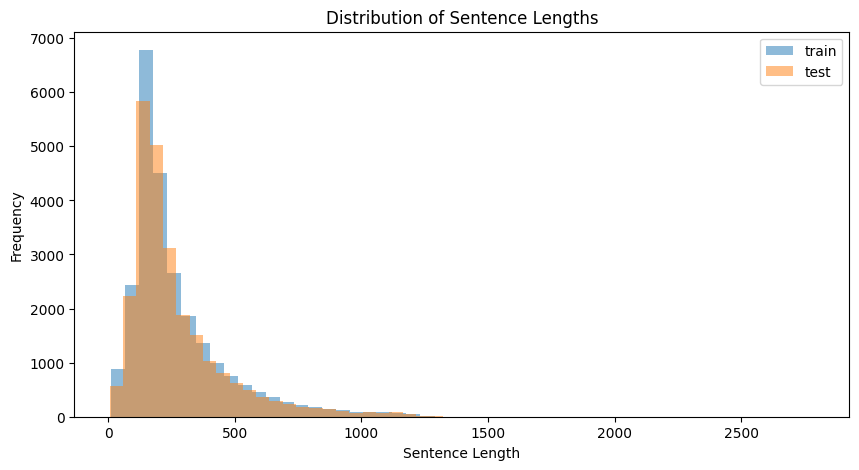

In [11]:
# plot the length of each array in train_coprus and test_coprus

train_lengths = [len(x) for x in train_tokenized]
test_lengths = [len(x) for x in test_tokenized]

plt.figure(figsize=(10, 5))
plt.hist(train_lengths, bins=50, alpha=0.5, label="train")
plt.hist(test_lengths, bins=50, alpha=0.5, label="test")
plt.xlabel("Sentence Length")
plt.ylabel("Frequency")
plt.title("Distribution of Sentence Lengths")
plt.legend()
plt.show()


In [12]:
max_lenght = 256

3. create a vocabulary using train_corpus

In [26]:
def yield_tokens(data_iter):
    for tokens in data_iter:
        yield tokens

vocab = build_vocab_from_iterator(yield_tokens(train_tokenized), specials=["<unk>", "<pad>"],  max_tokens=10000)
vocab.set_default_index(vocab["<unk>"])  # Set default index for unknown tokens

In [27]:
# the reult we got 'vocab' is a word dictionary
print(vocab['world'])
print(vocab['airplane'])
print(vocab['<pad>'])
print(vocab['<unk>'])

228
7544
1
0


In [28]:
len(vocab)

10000

3. Using the voab word dictionary numericalize each token in train_tokenized and test_tokenized.

In [29]:
# Step 3: Numericalize tokens
def numericalize_tokens(data):
    return [[vocab[token] for token in tokens] for tokens in data]

train_sequences = numericalize_tokens(train_tokenized)
test_sequences = numericalize_tokens(test_tokenized)

In [30]:
print(train_sequences[322])
print(test_sequences[444])

print(len(train_sequences[322]))
print(len(test_sequences[444]))

[66, 0, 8, 36, 2, 281, 22, 11, 160, 145, 3576, 8, 130, 4, 159, 2, 106, 1190, 258, 3, 67, 19, 29, 261, 8, 431, 83, 628, 10, 16, 22, 4, 11, 19, 28, 3982, 41, 2, 68, 3, 5, 73, 1040, 7, 68, 8, 0, 8, 6, 56, 17, 23, 17, 2, 17, 277, 17, 7, 17, 12, 22, 4, 25, 0, 97, 78, 4308, 10, 73, 16, 22, 10, 2274, 182, 45, 230, 34, 204, 12, 46, 2, 871, 523, 1164, 50, 7492, 18, 683, 31, 47, 1842, 3040, 3, 16, 9, 196, 47, 115, 98, 22, 37, 15, 104, 4, 66, 662, 21, 6, 100, 896, 5, 122, 56, 204, 488, 4, 155, 15, 196, 81, 2676, 183, 10, 746, 18, 4010, 313, 6, 192, 7, 117, 3, 616, 59, 11, 86, 29, 499, 23, 4, 126, 76, 31, 1209, 8, 464, 148, 68, 28, 16, 22, 3, 57, 29, 151, 11, 86, 29, 3245, 31, 4]
[503, 36, 1385, 3, 11, 86, 29, 80, 6, 192, 7, 16, 141, 4, 3374, 101, 12, 19, 29, 20, 60, 20, 2, 220, 0, 3, 26, 11, 322, 8, 2550, 109, 769, 12, 209, 28, 2, 8932, 8205, 4, 595, 302, 56, 32, 29, 325, 2, 1221, 7, 1181, 209, 212, 1314, 4, 126, 11, 77, 86, 379, 41, 106, 3, 48, 12, 19, 29, 42, 100, 4, 844, 11, 56, 834, 1039, 12,

4. pad sequences

In [31]:
# Pad sequences
def pad_sequences(sequences, max_legnth):
  tensor_seqs = [torch.tensor(seq[:max_legnth]) for seq in sequences]
  return pad_sequence(tensor_seqs, batch_first=True, padding_value=vocab['<pad>'])

train_padded = pad_sequences(train_sequences, 256)
test_padded = pad_sequences(test_sequences, 256)

In [32]:
print(train_padded[9443])
print(len(train_padded[0]))

tensor([  66,    9,    6,  821,  571, 3376, 1867,  547,   92,  113, 3780,    0,
           3,   76,   40,    2, 1445,    3,   21,    6, 8157,    0,  129,    5,
          59,  651, 5539,    4,   25,  105,  244,  195,    7,   16,   24,    9,
         113, 3639, 1029,    7,    0,    0,    3,    6,  163,   21,    6, 4760,
        4025,   20,    2,   24,   15,   14, 1083,   14,    4,  921,  673,    8,
          80,   16,  163, 7358,    3,   26,   37,  268,  104,   60,  371,    7,
           2,  307,   45, 1580,  102,    4,    0,    9,  351, 4888,   87,    2,
        1235, 3405,    3,   20,   11,   61,  432,  438, 2526,  136, 1320,   50,
          81,    0,    4, 1563,    0,    9,   28, 2210,   20,    2,   24,   15,
        1543, 1679,    3,    5,   37,    9,   62, 1184,   10,   16,  195,    4,
          11,   23,   38,  387,  343,    0,   10,   56,   51,  261,  125,   23,
          59,  303,    2,  163,    0,   84,    4,   25,   74,   98,  195,    7,
           2,   24,   13, 2308,   84,   

4. create a tensor datasets and using it create a DataLoader

In [33]:
# Create TensorDatasets
train_labels_tensor = torch.tensor(train_labels)
test_labels_tensor = torch.tensor(test_labels)

train_dataset = TensorDataset(train_padded, train_labels_tensor)
test_dataset = TensorDataset(test_padded, test_labels_tensor)

# Create DataLoader
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
for idx, exmaple in enumerate(train_loader):
  X, y = exmaple
  print(X.shape)
  print(y.shape)
  if idx == 10:
    break


# Create a model

In [35]:
class IMDBReivewClassifier(nn.Module):
  def __init__(self):
    super(IMDBReivewClassifier, self).__init__()
    # Embedding Layers
    self.embedding = nn.Embedding(num_embeddings = 10000, embedding_dim = 512)
    # LSTM layers
    self.lstm_layers = nn.LSTM(input_size = 512, hidden_size = 512, num_layers=2, batch_first=True, bidirectional=True)
    # Fully Connected Layers
    self.fc1 = nn.Linear(1024, 64)
    self.fc2 = nn.Linear(64, 1)


  def forward(self, x):
    x = self.embedding(x)
    output, (hn, cn) = self.lstm_layers(x)
    x = output.mean(dim=1)
    x = self.fc1(x)
    x = self.fc2(x)
    x = torch.sigmoid(x)
    return x

In [106]:
lstm_layer = nn.LSTM(input_size=512,
                     hidden_size=512,
                     num_layers=2,
                     batch_first=True,
                     bidirectional=False)

batch_size = 3
seq_length = 100
input_size = 512  # Must match the input_size of LSTM

input_tensor = torch.randn(batch_size, seq_length, input_size)
outputs, (hn, cn) = lstm_layer(input_tensor)
outputs.shape

torch.Size([3, 100, 512])

In [36]:
model = IMDBReivewClassifier()

Check model inference

In [102]:
batch_size = 32
seq_length = 256
vocab_size = 10000
example_tensor = torch.randint(low=0, high=vocab_size, size=(batch_size, seq_length), dtype=torch.long)

output = model(example_tensor.to(device))
print(output.shape)

torch.Size([32, 1])


In [38]:
output

tensor([[0.5074],
        [0.5077],
        [0.5091],
        [0.5087],
        [0.5086],
        [0.5085],
        [0.5081],
        [0.5078],
        [0.5085],
        [0.5083],
        [0.5080],
        [0.5082],
        [0.5076],
        [0.5092],
        [0.5084],
        [0.5079],
        [0.5077],
        [0.5075],
        [0.5088],
        [0.5079],
        [0.5081],
        [0.5079],
        [0.5093],
        [0.5091],
        [0.5089],
        [0.5080],
        [0.5082],
        [0.5083],
        [0.5081],
        [0.5075],
        [0.5089],
        [0.5074]], grad_fn=<SigmoidBackward0>)

In [39]:
model.to(device)

IMDBReivewClassifier(
  (embedding): Embedding(10000, 512)
  (lstm_layers): LSTM(512, 512, num_layers=2, batch_first=True, bidirectional=True)
  (fc1): Linear(in_features=1024, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=1, bias=True)
)

# Train the model

In [40]:
loss_fn = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [41]:
len(train_loader)

782

In [42]:
def calculate_accuracy(preds, labels):
  preds = (preds > 0.5).float()

  correct = (preds == labels).float()
  accuracy = correct.sum() / len(correct)
  return accuracy

In [43]:
def evaluate(model):
  model.eval()
  total_loss = 0
  total_accuracy = 0
  total_samples = 0

  with torch.no_grad():
    for inputs, labels in test_loader:
      inputs, labels = inputs.to(device), labels.to(device)
      predictions = model(inputs)
      labels = labels.unsqueeze(1).float()

      loss = loss_fn(predictions, labels)

      total_loss += loss.item() * inputs.size(0)
      total_accuracy += calculate_accuracy(predictions, labels) * inputs.size(0)
      total_samples += inputs.size(0)

    total_accuracy = float(total_accuracy) / total_samples
    total_loss = float(total_loss) / total_samples

  return total_loss, total_accuracy

In [44]:
evaluate(model)

(0.6934077616310119, 0.48968)

In [46]:
def train_one_epoch():
  model.train()

  for batch_idx, (input, label) in enumerate(train_loader):
    model.train()
    input, label = input.to(device), label.to(device)

    # forward propagation
    pred = model(input)
    # compute loss
    loss = loss_fn(pred, label.unsqueeze(1).float())
    # do backward propagation
    optimizer.zero_grad()
    loss.backward()
    # update weights
    optimizer.step()

    if batch_idx % 100 == 0 or batch_idx == len(train_loader)-1:
      accuracy = calculate_accuracy(pred, label.unsqueeze(1).float())
      print(f"{batch_idx} batch - loss: {loss}, accuracy: {accuracy}")


epochs = 1
for epoch in range(epochs):
  print(f"Epoch {epoch+1}")
  train_one_epoch()
  val_loss, val_accuracy = evaluate(model)
  print(f"Validation - Loss: {val_loss}, Accuracy: {val_accuracy}")
  print("=================\n")

Epoch 1
0 batch - loss: 0.5814475417137146, accuracy: 0.6875
100 batch - loss: 0.4441051483154297, accuracy: 0.8125
200 batch - loss: 0.463911771774292, accuracy: 0.75
300 batch - loss: 0.36113518476486206, accuracy: 0.78125
400 batch - loss: 0.2866861820220947, accuracy: 0.875
500 batch - loss: 0.21282553672790527, accuracy: 0.9375
600 batch - loss: 0.20680581033229828, accuracy: 0.9375
700 batch - loss: 0.32904282212257385, accuracy: 0.875
781 batch - loss: 0.2657952308654785, accuracy: 0.875
Validation - Loss: 0.29989119903564454, Accuracy: 0.87024



## Inferencing

In [95]:
def inference(review, label):

  tokenized = tokenize_data([review])
  sequence = numericalize_tokens(tokenized)
  padded = pad_sequences(sequence, 256)

  logit = model(padded.to(device))
  pred = 0
  if pred >= 0.5:
    pred = 1
  else:
    pred = 0

  print(f"Review Sentence: {review}")
  print(f"Prediction: {pred}")
  print(f"True Label: {label}")

In [98]:
idx = 45
inference(test_corpus[idx], test_labels[idx])

Review Sentence: STMD! is not a terrible movie, but it IS quite forgettable. The lighting is intentionally poor in many scenes and unintentionally poor in all the rest, so you are likely to come out of a viewing with a headache or eye-strain. Special effects are imaginative, but obvious. The gratuitous nudity essential for teen slasher flicks is there, of course, along with the archetypical teenagers, but the whole movie just doesn't gel. What was needed was some snappier dialogue and more tongue-in-cheek humor.<br /><br />I can't really recommend that you use your time watching this movie. I often give a nod to a movie based on just a scene or two that demonstrates imagination or humor, but these are sadly lacking in this film.
Prediction: 0
True Label: 0


In [99]:
idx = 431
inference(test_corpus[idx], test_labels[idx])

Review Sentence: the movie is precious, and cage is a babe. <br /><br />but will anyone agree with me in saying that the punk representation in this movie is ATROCIOUS?!?! <br /><br />where's the clash? the ramones?? misfits? social distortion? the cramps?? sex pistols?! ANYONE?!?!?!?! the music is this movie is incredibly disappointing! at LEAST they play the cure.<br /><br />plus, randy's feathered hair and pleated khakis...<br /><br />this definitely looks like a movie about "punks" the way that a bunch of movie industry squares see punks.<br /><br />although it's a 90's movie, SLC punk paints a much more accurate picture of the punk rock scene in the early 1980's. just sayin'.
Prediction: 0
True Label: 0
